In [2]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

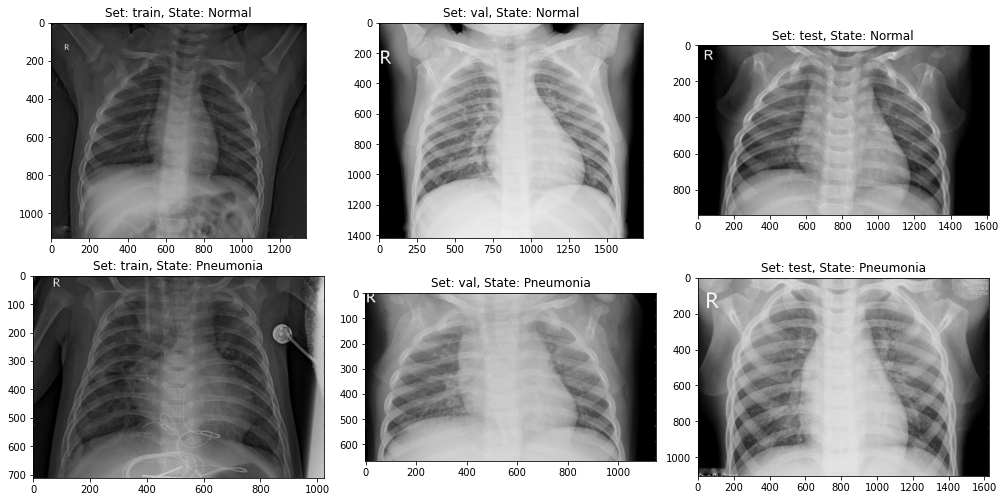

In [3]:
#plotting exemplary images from dataset

fig, ax = plt.subplots(2, 3, figsize=(14, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _type in enumerate(['train', 'val', 'test']):
    
    set_path = input_path+_type
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, State: Normal'.format(_type))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, State: Pneumonia'.format(_type))

In [4]:
img_size = 150
labels = ["NORMAL","PNEUMONIA"]

def data_prep(data_dir):
    data =[]
    counter = 0
    data1=[]
    data2=[]
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
#             print(os.path.join(path,img))
#             clear_output(wait=True)
            if 'test' in path:
                if(img.endswith('.jpeg')):
                    
                    img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
                    resize_arr = cv2.resize(img_arr,(img_size,img_size))
                    data.append([resize_arr,class_num])
                    if counter%2==0:
                        data1.append([resize_arr,class_num])
                    else:
                        data2.append(([resize_arr,class_num]))
                    counter+=1
            if(img.endswith('.jpeg')):
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
                resize_arr = cv2.resize(img_arr,(img_size,img_size))
                data.append([resize_arr,class_num])
    if 'test' in path:
        return np.array(data1), np.array(data2)
    else: 
        return np.array(data)

In [5]:
def train_val_stats(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [6]:
train = data_prep('../input/chest-xray-pneumonia//chest_xray/chest_xray/train')
test1, test2 = data_prep('../input/chest-xray-pneumonia//chest_xray/chest_xray/test')
val = data_prep('../input/chest-xray-pneumonia//chest_xray/chest_xray/val')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

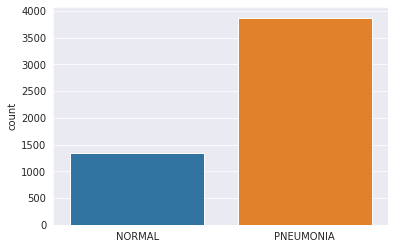

In [7]:
#plotting number of samples of each class - the dataset is imbalanced
count = []
for cnt in train:
    if (cnt[1]==0):
        count.append("NORMAL")
    else:
        count.append("PNEUMONIA")

sns.set_style('darkgrid')
sns.countplot(count)

In [8]:
x_train = []
y_train = []

x_test = []
y_test = []

x_test2 = []
y_test2 = []

x_val = []
y_val = []

for features, label in train:
    x_train.append(features)
    y_train.append(label)
    
for features, label in test1:
    x_test.append(features)
    y_test.append(label)

for features,label in test2:
    x_test2.append(features)
    y_test2.append(label)
    
for features, label in val:
    x_val.append(features)
    y_val.append(label)

In [9]:
# Normalizing the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_test2 = np.array(x_test2)/255
x_val = np.array(x_val) / 255

In [10]:
# Reshaping the data
# Note: using greyscale image that is why used 1 if it was RGB image then it would be 3

x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

x_test2 = x_test2.reshape(-1,img_size,img_size,3)
y_test2 = np.array(y_test2)
y_test2 = y_test2.reshape(-1,1)

x_val = x_val.reshape(-1,img_size,img_size,3)
y_val = np.array(y_val)
y_val = y_val.reshape(-1,1)

In [11]:

def data_aug(img_dimensions, batch_size, class_mode):
    #manipulacja danymi
    #vertical_flip=True
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=10,width_shift_range=0.2, height_shift_range=0.2,brightness_range=[0.4,1.5])
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # generator danych jest wejściem do sieci
    #generator danych treningowych 
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dimensions, img_dimensions), 
    batch_size=batch_size, 
    class_mode=class_mode, 
    shuffle=True)

    #generator danych testowych
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dimensions, img_dimensions), 
    batch_size=batch_size, 
    class_mode=class_mode, 
    shuffle=True)
    
    # zbiór testowy do obliczania metryk
    test_data = []
    test_labels = []
    

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dimensions, img_dimensions))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    return train_gen, test_gen, test_data, test_labels

In [12]:
# DataGenerator object to introduce more variation to the training dataset
datagen = ImageDataGenerator(
        # featurewise_center=False,  # set input mean to 0 over the dataset
        # samplewise_center=False,  # set each sample mean to 0
        # featurewise_std_normalization=False,  # divide inputs by std of the dataset
        # samplewise_std_normalization=False,  # divide each input by its std
        # zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1) # randomly shift images vertically (fraction of total height)
        # horizontal_flip = True,  # randomly flip images
        # vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
#Model CNN with 5 convolution blocks - model_1
img_dims = 150
inputs = Input(shape=(img_dims, img_dims, 3))

# 1 blok konwolucyjny
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 2 blok konwolucyjny
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
# 3 blok konwolucyjny
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# 4 blok konwolucyjny
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# 5 blok konwolucyjny
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Warstwa spłaszczająca
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model_1 = Model(inputs=inputs, outputs=output)
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

2022-06-01 06:25:57.252515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 06:25:57.362702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 06:25:57.363441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 06:25:57.364523: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)
            
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [15]:
#compiling ResNet18
model_2 = ResNet18(1)
model_2.build(input_shape = (None,150,150,3))
model_2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model_2.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  9472      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  74368     
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple                  74368     
_________________________________________________________________
resnet_block_2 (ResnetBlock) multiple               

In [16]:
#DenseNet201 model
from tensorflow.keras.applications import DenseNet121
epochs = 10
batch_size=32

model_densetnet = tf.keras.applications.DenseNet201(input_tensor=inputs,input_shape=(img_dims,img_dims,3),include_top=False,weights='imagenet',pooling='avg')
model_densetnet.trainable = False
input = model_densetnet.input

x = model_densetnet.output
output = tf.keras.layers.Dense(2, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=input, outputs=output)

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
#training model_1
STEPS = len(x_train) / 32
hist_1 = model_1.fit(
           datagen.flow(x_train,y_train,batch_size = 32), steps_per_epoch=STEPS, 
           epochs=10, validation_data=datagen.flow(x_test2, y_test2),
              callbacks=[checkpoint, lr_reduce])
#datagen.flow(x_train,y_train,batch_size = 32), steps_per_epoch=STEPS, batch_size = 32, epochs=10, validation_data = datagen.flow(x_val, y_val),

In [ ]:
#training model_2
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
STEPS = len(x_train) / 32
hist_2 = model.fit(datagen.flow(x_train,y_train,batch_size = 32), steps_per_epoch=STEPS, batch_size = 32, epochs=10, validation_data = datagen.flow(x_val, y_val),callbacks=[learning_rate_reduction])

In [ ]:
#training DenseNet201 on X-Ray dataset
hist_3 = densenet201.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size)

10/10 [==============================] - 1s 20ms/step - loss: 0.1977 - accuracy: 0.9327


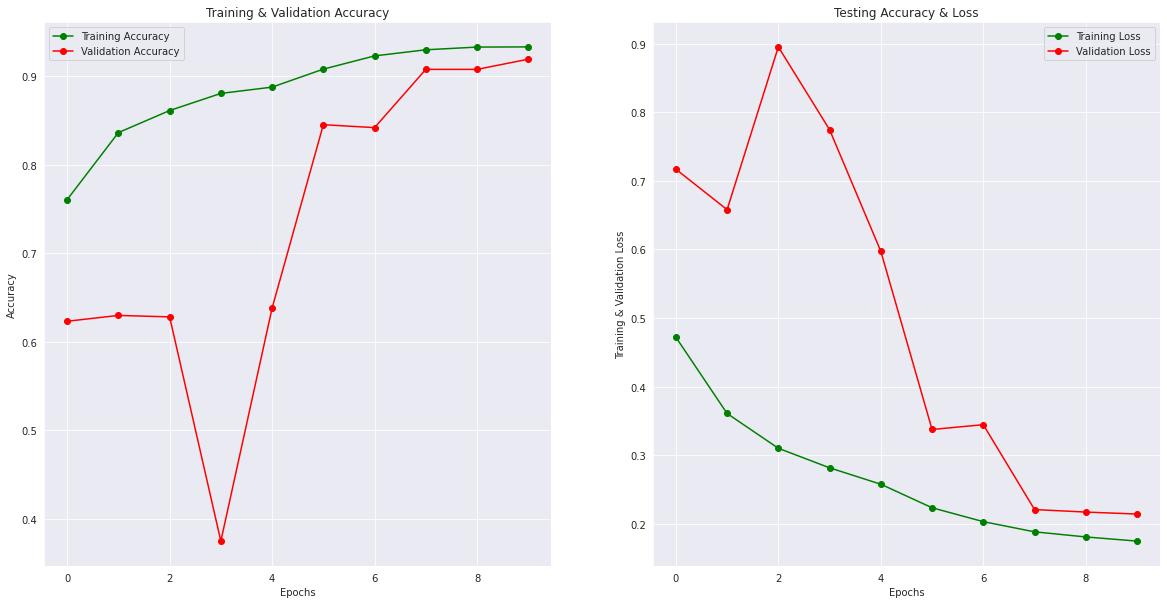

In [20]:
#model_1 evaluation
model_1.evaluate(x_test, y_test)
train_val_stats(hist_1)

10/10 [==============================] - 1s 25ms/step - loss: 0.1806 - accuracy: 0.9423


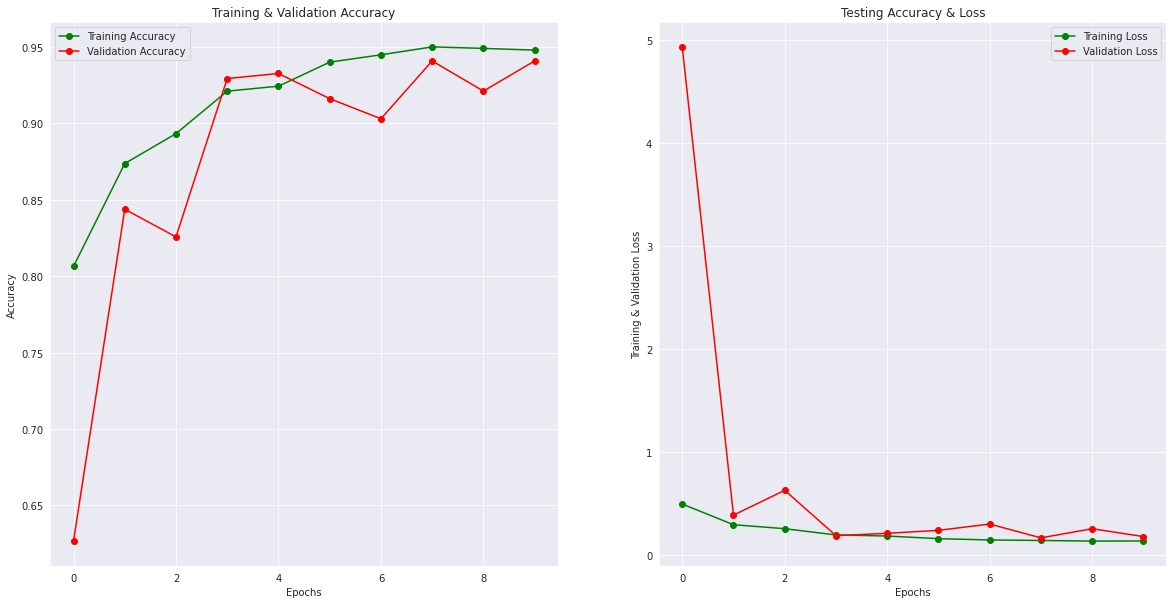

In [22]:
#model_2 evaluation
model_2.evaluate(x_test, y_test)
train_val_stats(hist_2)

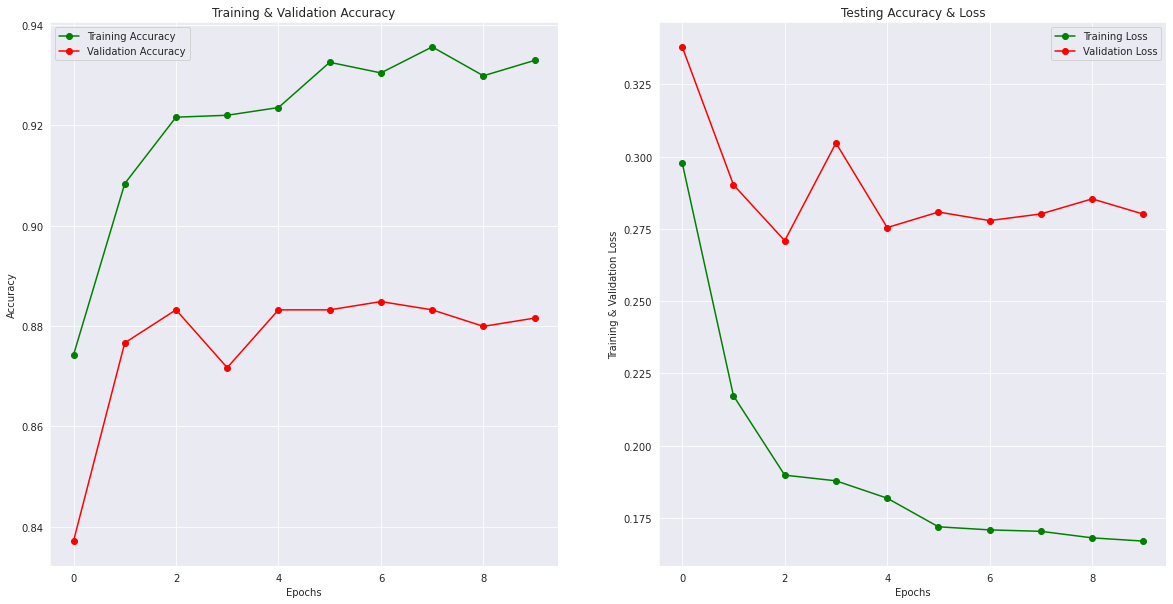

In [33]:
#model_3 evaluation
#model_3.evaluate(x_test, y_test)
train_val_stats(hist_3)

In [23]:
model_1.save('model_1.tf')

2022-06-01 07:02:36.800528: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [24]:
model_2.save('model_2.tf')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
model_3.save('model_3.tf')

In [35]:
'''ensemble learning part'''
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'model_' + str(i + 1) + '.tf'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 
# generate 2d classification dataset
trainX,testX = x_train, x_test
trainy,testy = y_train, y_test
# load all models
n_members = 3
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset


>loaded model_1.tf
>loaded model_2.tf
>loaded model_3.tf
Loaded 3 models


In [ ]:
model_3 = model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.evaluate(x_test,y_test)

In [34]:
for n,model in enumerate(members):
    testy_enc = to_categorical(testy, num_classes=2)
    if n==2:
        model = model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    _, acc = model.evaluate(testX, testy)
    print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

 1/10 [==>...........................] - ETA: 0s - loss: 0.2889 - accuracy: 0.9062

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


10/10 [==============================] - 0s 25ms/step - loss: 0.1977 - accuracy: 0.9327
Model Accuracy: 0.933
10/10 [==============================] - 1s 54ms/step - loss: 0.1806 - accuracy: 0.9423
Model Accuracy: 0.942


AttributeError: 'NoneType' object has no attribute 'evaluate'

In [17]:
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'
img_dims = 150
epochs = 10
batch_size = 32
train_gen, test_gen, test_data, test_labels = data_aug(img_dims, batch_size, "binary")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [19]:
hist_1 = model_1.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

2022-06-01 06:27:34.376193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-01 06:27:36.988789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 98s 549ms/step - loss: 0.4719 - accuracy: 0.7607 - val_loss: 0.7168 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 91s 557ms/step - loss: 0.3607 - accuracy: 0.8365 - val_loss: 0.6578 - val_accuracy: 0.6299
Epoch 3/10
163/163 [==============================] - 90s 555ms/step - loss: 0.3100 - accuracy: 0.8614 - val_loss: 0.8951 - val_accuracy: 0.6283
Epoch 4/10
163/163 [==============================] - 90s 550ms/step - loss: 0.2815 - accuracy: 0.8808 - val_loss: 0.7744 - val_accuracy: 0.3750
Epoch 5/10
163/163 [==============================] - 91s 551ms/step - loss: 0.2576 - accuracy: 0.8878 - val_loss: 0.5971 - val_accuracy: 0.6382

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
163/163 [==============================] - 91s 556ms/step - loss: 0.2233 - accuracy: 0.9082 - val_loss: 0.3374 - val_accuracy: 0.8454
Epoch 7/10
163/163 [==============================] - 90s 55

In [21]:
hist_2 = model_2.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 90s 535ms/step - loss: 0.4922 - accuracy: 0.8064 - val_loss: 4.9349 - val_accuracy: 0.6266
Epoch 2/10
163/163 [==============================] - 87s 532ms/step - loss: 0.2913 - accuracy: 0.8737 - val_loss: 0.3843 - val_accuracy: 0.8438
Epoch 3/10
163/163 [==============================] - 87s 534ms/step - loss: 0.2525 - accuracy: 0.8932 - val_loss: 0.6253 - val_accuracy: 0.8257

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 87s 534ms/step - loss: 0.1917 - accuracy: 0.9210 - val_loss: 0.1847 - val_accuracy: 0.9293
Epoch 5/10
163/163 [==============================] - 87s 532ms/step - loss: 0.1812 - accuracy: 0.9243 - val_loss: 0.2076 - val_accuracy: 0.9326

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 87s 537ms/step - loss: 0.1555 - accuracy: 0.9400 - val_loss

In [27]:
train_gen, test_gen, test_data, test_labels = data_aug(img_dims, batch_size, "categorical")
tf.config.run_functions_eagerly(True)
hist_3 = model_3.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
163/163 [==============================] - 133s 815ms/step - loss: 0.2978 - accuracy: 0.8742 - val_loss: 0.3379 - val_accuracy: 0.8372
Epoch 2/10
163/163 [==============================] - 129s 791ms/step - loss: 0.2173 - accuracy: 0.9084 - val_loss: 0.2902 - val_accuracy: 0.8766
Epoch 3/10
163/163 [==============================] - 131s 801ms/step - loss: 0.1898 - accuracy: 0.9216 - val_loss: 0.2709 - val_accuracy: 0.8832

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 128s 786ms/step - loss: 0.1879 - accuracy: 0.9220 - val_loss: 0.3047 - val_accuracy: 0.8717
Epoch 5/10
163/163 [==============================] - 128s 784ms/step - loss: 0.1819 - accuracy: 0.9235 - val_loss: 0.2755 - val_accuracy: 0.8832

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 129s 788ms/step - loss: 0.1720 - accuracy: 0.9325 - va